In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging

import numpy as np
from tqdm import tqdm
from skimage import io

# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes
data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [2]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('../train_source_images.txt')
validate_ids = load_text_ids('../val_source_images.txt')
test_ids = load_text_ids('../test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [3]:
def load_images(dir_path):

    tile_dir = dir_path / Path('tiles')
    images = {}

    for root, dirs, files in os.walk(tile_dir):
        for file in files:
            file = Path(file)
            if file.suffix == '.png':
                fp = os.path.join(root, file)
                
                # Extract the image class label from the filepath. This (and additional) info is also in the label jsons
                image_class = Path(root).stem
                
                # Initalize this dictionary class key if needed
                if image_class not in images.keys():
                    images[image_class] = []
                
                # Load the image, save it to our list
                img = io.imread(fp)
                images[image_class].append(img)

    # Convert list of image arrays into a per-class array
    for key in images.keys():
        images[key] = np.array(images[key])
        
    return images

np_datasets_train = []
np_datasets_val = []
np_datasets_test = []
logging.info(f'Loading ML data from {len(subdirs)} subframes.')
for idx, subdir in tqdm(enumerate(subdirs), desc='Creating Dataset as Numpy array'):
    full_path = data_head_dir / subdir
    if subdir_splits[idx] == 'train':
        np_datasets_train.append(load_images(full_path))
    elif subdir_splits[idx] == 'validate':
        np_datasets_val.append(load_images(full_path))
    else:
        np_datasets_test.append(load_images(full_path))

08:43:49 | INFO  | 2759750330      | Loading ML data from 414 subframes.
Creating Dataset as Numpy array: 414it [01:37,  4.24it/s]


In [4]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, np_datasets):
        self.images = []
        self.labels = []
        for np_dataset in np_datasets:
            for key, value in np_dataset.items():
                for i in range(value.shape[0]):
                    image = torch.from_numpy(value[i]).unsqueeze(0).float() / 255.0  # Convert to float and normalize
                    label = 0 if key == 'background' else 1  # Assign labels based on key
                    self.images.append(image)
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        return image, label

train_dataset = CustomDataset(np_datasets_train)
val_dataset = CustomDataset(np_datasets_val)
test_dataset = CustomDataset(np_datasets_test)


In [5]:
len(train_dataset), len(val_dataset), len(test_dataset)

(29679, 11286, 12823)

Training Loss: 1.0224, Training Error: 0.2380


Training Loss: 0.3545, Training Error: 0.1573


Training Loss: 0.2492, Training Error: 0.1053


Training Loss: 0.2024, Training Error: 0.0829


Training Loss: 0.1639, Training Error: 0.0640


Training Loss: 0.1260, Training Error: 0.0488


Training Loss: 0.1041, Training Error: 0.0398


Training Loss: 0.1547, Training Error: 0.0559
Early stopping at epoch 7


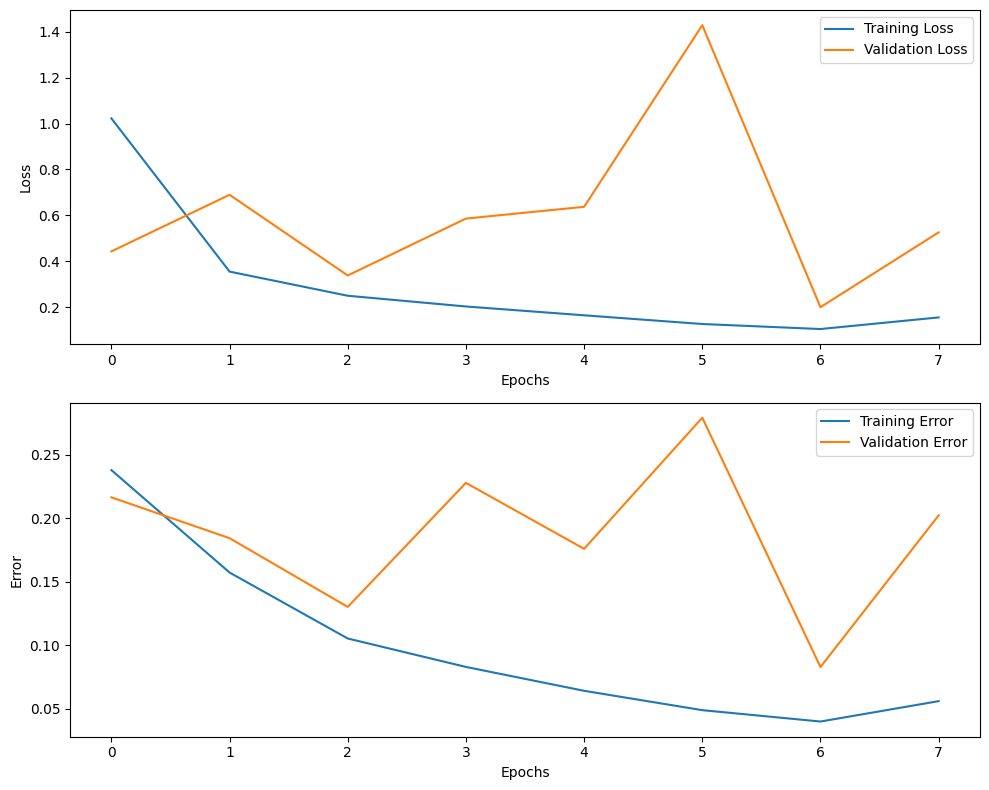

Precision: 0.9456, Recall: 0.9469, F1 Score: 0.9463


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data.dataset import random_split
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import copy

# Assuming you have defined CustomDataset as mentioned before

# Define DataLoader for training and validation sets with data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
])

train_dataset.transform = transform  # Set transform for the training dataset
val_dataset.transform = transforms.ToTensor()  # No augmentation for the validation dataset
test_dataset.transform = transforms.ToTensor()  # No augmentation for the validation dataset

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define your CNN + MLP model
class CNNMLPModel(nn.Module):
    def __init__(self):
        super(CNNMLPModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
        )
        self.mlp = nn.Sequential(
            nn.Linear(64 * 37 * 37, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        return x

# Move the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNMLPModel().to(device)
best_model = model
best_val_error = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

# Training loop with tqdm and loss printing
num_epochs = 20
train_losses, val_losses = [], []
train_errors, val_errors = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_error = 1.0 - train_corrects.double() / len(train_dataset)
    train_errors.append(train_error.item())
    print(f'Training Loss: {train_loss:.4f}, Training Error: {train_error:.4f}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_error = 1.0 - val_corrects.double() / len(val_dataset)
    if val_error < best_val_error:
        best_model = copy.deepcopy(model)
    val_errors.append(val_error.item())

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    # Early stopping
    if epoch > 5 and val_losses[-1] > val_losses[-2]:
        print(f"Early stopping at epoch {epoch}")
        break

# Plot training and validation losses and errors
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_errors, label='Training Error')
ax2.plot(val_errors, label='Validation Error')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error')
ax2.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
model = best_model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Evaluating', leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


efficientnet_b0 net's fc layer in_features num is: 1280
resnet50 net's fc layer in_features num is: 2048
vgg16 net's fc layer in_features num is: 25088
efficientnet_b0 Epoch 1/10, Training Loss: 0.7354544997215271, Validation Loss: 0.672601787383947, Training Error: 0.4428046767074363, Validation Error: 0.31747297536771224
efficientnet_b0 Epoch 2/10, Training Loss: 0.735215961933136, Validation Loss: 0.6724135444662666, Training Error: 0.44202971798241175, Validation Error: 0.3092326776537303
efficientnet_b0 Epoch 3/10, Training Loss: 0.7391456365585327, Validation Loss: 0.6732206880036047, Training Error: 0.43973853566494825, Validation Error: 0.3036505404926457
efficientnet_b0 Epoch 4/10, Training Loss: 0.7457312941551208, Validation Loss: 0.6731265284920817, Training Error: 0.44337747228680213, Validation Error: 0.3211944001417686
efficientnet_b0 Epoch 5/10, Training Loss: 0.7430984973907471, Validation Loss: 0.6737209076935289, Training Error: 0.4450958590248998, Validation Error: 

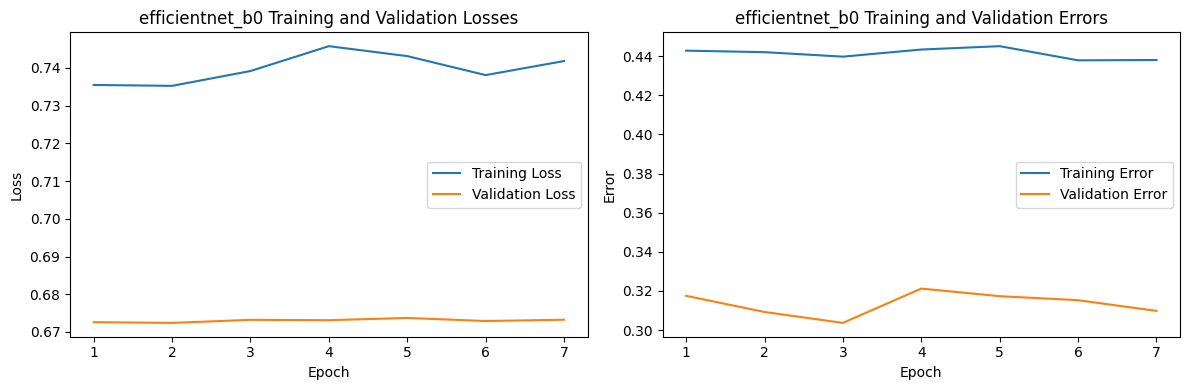

efficientnet_b0 - Precision: 0.5662, Recall: 0.4461, F1 Score: 0.4339
resnet50 Epoch 1/10, Training Loss: 0.7097075581550598, Validation Loss: 0.670568364488203, Training Error: 0.593180363219785, Validation Error: 0.36239588871167816
resnet50 Epoch 2/10, Training Loss: 0.7098920345306396, Validation Loss: 0.6702983813770746, Training Error: 0.5918663027730044, Validation Error: 0.36275031011873116
resnet50 Epoch 3/10, Training Loss: 0.709811270236969, Validation Loss: 0.6691356516827298, Training Error: 0.5909902624751509, Validation Error: 0.3573453836611732
resnet50 Epoch 4/10, Training Loss: 0.7060785889625549, Validation Loss: 0.6692942801841908, Training Error: 0.5905522423262239, Validation Error: 0.35858585858585856
resnet50 Epoch 5/10, Training Loss: 0.7010472416877747, Validation Loss: 0.6704489585369994, Training Error: 0.5911587317631996, Validation Error: 0.36292752082225765
resnet50 Epoch 6/10, Training Loss: 0.7087073922157288, Validation Loss: 0.6692337878679825, Traini

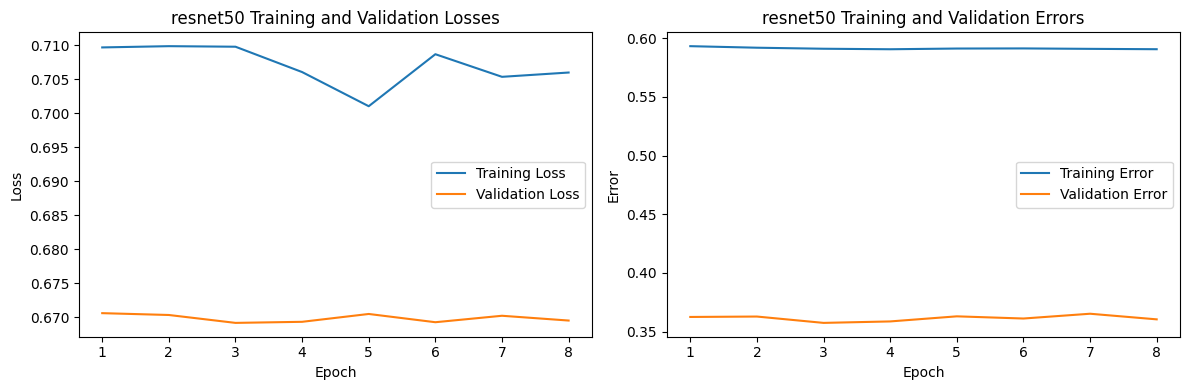

resnet50 - Precision: 0.4084, Recall: 0.3311, F1 Score: 0.2908
vgg16 Epoch 1/10, Training Loss: 0.7358022332191467, Validation Loss: 0.6819366775663559, Training Error: 0.5693251120320766, Validation Error: 0.3291688818004608
vgg16 Epoch 2/10, Training Loss: 0.7358022332191467, Validation Loss: 0.6819366775663559, Training Error: 0.5693251120320766, Validation Error: 0.3291688818004608
vgg16 Epoch 3/10, Training Loss: 0.7358022332191467, Validation Loss: 0.6819366775663559, Training Error: 0.5693251120320766, Validation Error: 0.3291688818004608
vgg16 Epoch 4/10, Training Loss: 0.7358022332191467, Validation Loss: 0.6819366775663559, Training Error: 0.5693251120320766, Validation Error: 0.3291688818004608
vgg16 Epoch 5/10, Training Loss: 0.7358022332191467, Validation Loss: 0.6819366775663559, Training Error: 0.5693251120320766, Validation Error: 0.3291688818004608
Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
vgg16 Epoch 6/10, Training Loss: 0.7358022332191467, Validat

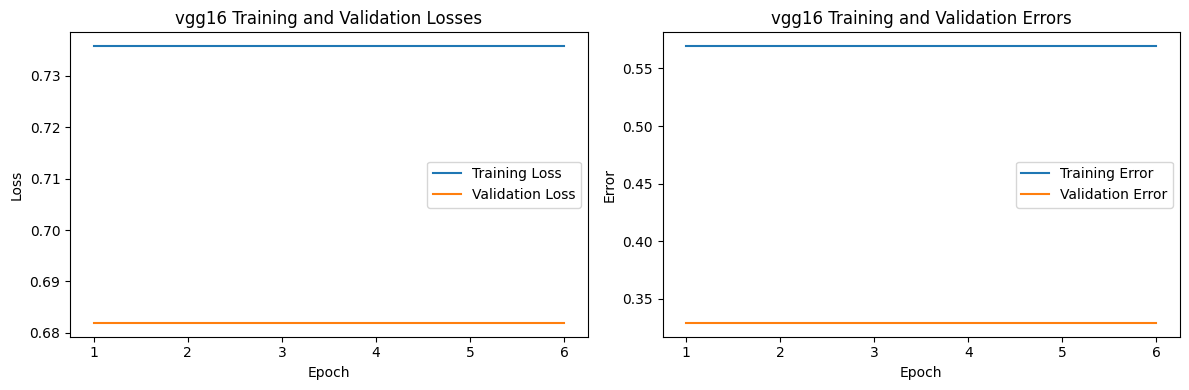

vgg16 - Precision: 0.6035, Recall: 0.3649, F1 Score: 0.2357


In [53]:
from torchvision import models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_names = ['efficientnet_b0', 'resnet50', 'vgg16']
models_dict = {}
for model_name in model_names:
    if model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        last_layer_name, last_layer = list(model.named_children())[-1]
        linear_layer = last_layer[1]
        in_features = linear_layer.in_features
        print(f'efficientnet_b0 net\'s fc layer in_features num is: {in_features}')
        
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        last_layer_name, last_layer = list(model.named_children())[-1]
        in_features = last_layer.in_features
        print(f'resnet50 net\'s fc layer in_features num is: {in_features}')
        
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        last_layer_name, last_layer = list(model.named_children())[-1]
        linear_layer = last_layer[0]
        in_features = linear_layer.in_features
        print(f'vgg16 net\'s fc layer in_features num is: {in_features}')
    
    # Remove the last fully connected layer
    model = nn.Sequential(*list(model.children())[:-1])
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    models_dict[model_name] = model

class Classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        x = self.relu(x)
        x = self.softmax(x)
        return x

def train_model(model, model_name, train_loader, val_loader, num_epochs=10, lr=0.001, patience=5):
    # Define the classifier
    if model_name == 'efficientnet_b0':
        classifier = Classifier(1280, 2).to(device)
    elif model_name == 'resnet50':
        classifier = Classifier(2048, 2).to(device)
    else:
        classifier = Classifier(25088, 2).to(device)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_errors = []
    val_errors = []
    
    for epoch in range(num_epochs):
        model.train()
        classifier.train()
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = torch.cat([inputs] * 3, dim=1).to(device)
            labels = labels.to(device)
            
            # Forward pass
            features = model(inputs)
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            
            # Compute training error
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_accuracy = correct_train / total_train
        train_errors.append(1 - train_accuracy)
        
        # Validation
        model.eval()
        classifier.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = torch.cat([inputs] * 3, dim=1).to(device)
                labels = labels.to(device)

                features = model(inputs)
                outputs = classifier(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Compute validation error
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_errors.append(1 - val_accuracy)
        val_loss /= len(val_loader)

        # Print training and validation losses
        print(f'{model_name} Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss}, Training Error: {train_errors[-1]}, Validation Error: {val_errors[-1]}')
        train_losses.append(loss.item())
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

        # Update scheduler
        scheduler.step(val_loss)

        
    # Plot training and validation losses
    epochs = np.arange(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training and Validation Losses')
    plt.legend()

    # Plot errors
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_errors, label='Training Error')
    plt.plot(epochs, val_errors, label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(f'{model_name} Training and Validation Errors')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_model, classifier

def evaluate_model(model, test_loader, classifier):
    model.eval()
    classifier.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = torch.cat([inputs] * 3, dim=1).to(device)
            labels = labels.to(device)
            features = model(inputs)
            outputs = classifier(features)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return precision, recall, f1

for model_name, model in models_dict.items():
    best_model_state_dict, classifier = train_model(model, model_name, train_loader, val_loader)
    model.load_state_dict(best_model_state_dict)

    # Evaluate the model
    precision, recall, f1 = evaluate_model(model, test_loader, classifier)

    # Print or store the metrics
    print(f'{model_name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

The results from transfer learning exhibit a significant decrease in performance compared to our previously trained CNN+MLP model. In the earlier test set, we achieved favorable metrics with Precision: 0.9456, Recall: 0.9469, and F1 Score: 0.9463, indicating a satisfactory outcome. However, when applying transfer learning with EfficientNetB0, ResNet50, and VGG16, the results fall notably short. Specifically, EfficientNetB0 yielded Precision: 0.5662, Recall: 0.4461, and F1 Score: 0.4339; ResNet50 yielded Precision: 0.4084, Recall: 0.3311, and F1 Score: 0.2908; and VGG16 yielded Precision: 0.6035, Recall: 0.3649, and F1 Score: 0.2357. These values reflect a significant decline in performance when utilizing transfer learning with the mentioned models.

This discrepancy may be attributed to the extensive freezing of parameters, allowing only the final fully connected layer to be trainable. Furthermore, analysis of the training loss curve reveals minimal changes in loss with an increase in the number of epochs.

Hence, this suggests that achieving substantial improvements, even when utilizing pre-trained parameters and freezing most layers while training only the fully connected (fc) layer, may pose a challenge. This challenge may arise due to the pre-trained parameters being derived from training on natural image datasets such as ImageNet, and potential significant differences between those datasets and the one used in the current experiment.

efficientnet_b0 net's fc layer in_features num is: 1280
resnet50 net's fc layer in_features num is: 2048
vgg16 net's fc layer in_features num is: 25088
efficientnet_b0 Epoch 1/10, Training Loss: 0.31352290511131287, Validation Loss: 0.4746675917321006, Training Error: 0.03268304188146498, Validation Error: 0.16400850611376927
efficientnet_b0 Epoch 2/10, Training Loss: 0.3192176818847656, Validation Loss: 0.4693913473247808, Training Error: 0.015532868358098306, Validation Error: 0.15922381711855393
efficientnet_b0 Epoch 3/10, Training Loss: 0.31340914964675903, Validation Loss: 0.4986048017517995, Training Error: 0.011422217729707862, Validation Error: 0.1902356902356902
efficientnet_b0 Epoch 4/10, Training Loss: 0.31330564618110657, Validation Loss: 0.42839283929706296, Training Error: 0.015027460493951983, Validation Error: 0.11660464292043238
efficientnet_b0 Epoch 5/10, Training Loss: 0.31329619884490967, Validation Loss: 0.40339206335908273, Training Error: 0.013814481620000651, Va

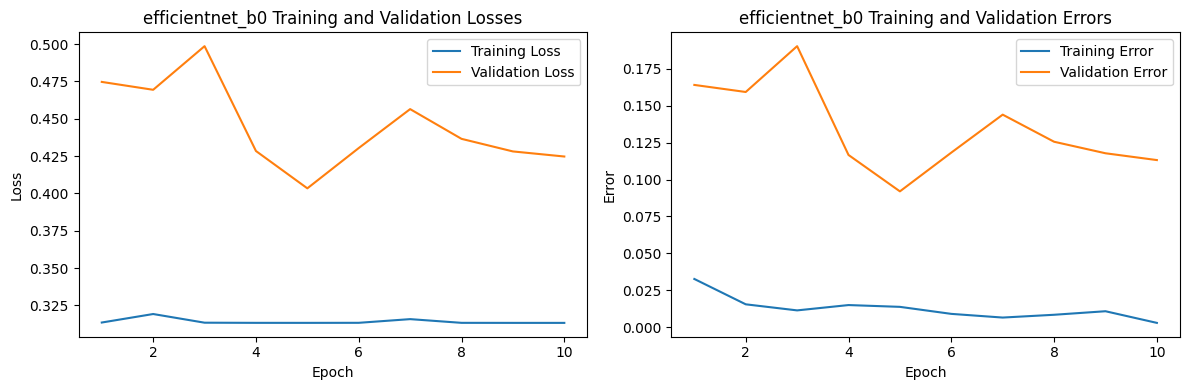

efficientnet_b0 - Precision: 0.9685, Recall: 0.9683, F1 Score: 0.9683
resnet50 Epoch 1/10, Training Loss: 0.31335291266441345, Validation Loss: 0.5695943512485526, Training Error: 0.09875669665419995, Validation Error: 0.27042353358142834
resnet50 Epoch 2/10, Training Loss: 0.31328606605529785, Validation Loss: 0.6020017953242286, Training Error: 0.04056740456214836, Validation Error: 0.30568846358320045
resnet50 Epoch 3/10, Training Loss: 0.3132677376270294, Validation Loss: 0.3977806079859114, Training Error: 0.0307287981400991, Validation Error: 0.08745348219032434
resnet50 Epoch 4/10, Training Loss: 0.31329959630966187, Validation Loss: 0.9802534369762335, Training Error: 0.02877455439873311, Validation Error: 0.6718943824206982
resnet50 Epoch 5/10, Training Loss: 0.31327974796295166, Validation Loss: 0.7230321970363122, Training Error: 0.028370228107416073, Validation Error: 0.42557150451887293
resnet50 Epoch 6/10, Training Loss: 1.3129676580429077, Validation Loss: 0.428099915637

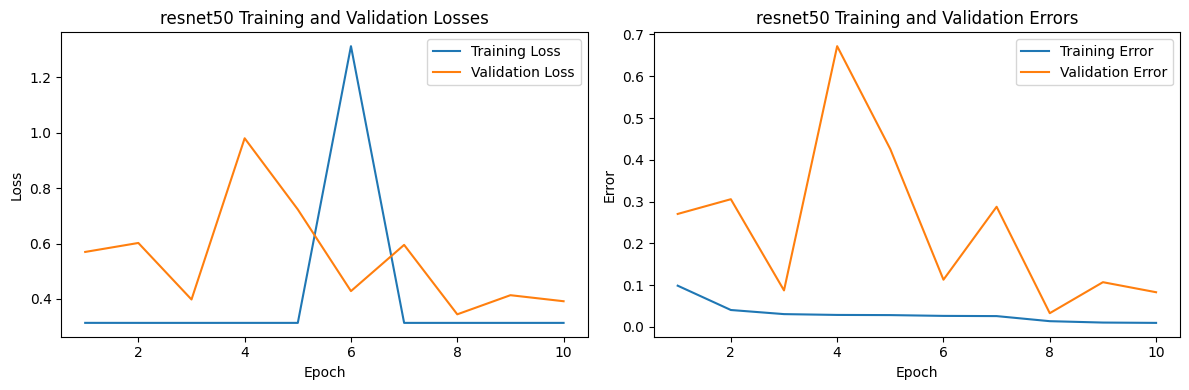

resnet50 - Precision: 0.9484, Recall: 0.9485, F1 Score: 0.9484
vgg16 Epoch 1/10, Training Loss: 0.6931474208831787, Validation Loss: 0.6931474801510741, Training Error: 0.5878230398598335, Validation Error: 0.32181463760411133
vgg16 Epoch 2/10, Training Loss: 0.6931474208831787, Validation Loss: 0.6931474801510741, Training Error: 0.5877556521446141, Validation Error: 0.32181463760411133
vgg16 Epoch 3/10, Training Loss: 0.6931474208831787, Validation Loss: 0.6931474801510741, Training Error: 0.5877556521446141, Validation Error: 0.32181463760411133
vgg16 Epoch 4/10, Training Loss: 0.6931474208831787, Validation Loss: 0.6931474801510741, Training Error: 0.5877556521446141, Validation Error: 0.32181463760411133
vgg16 Epoch 5/10, Training Loss: 0.6931474208831787, Validation Loss: 0.6931474801510741, Training Error: 0.5877556521446141, Validation Error: 0.32181463760411133
Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
vgg16 Epoch 6/10, Training Loss: 0.6931474208831787, Va

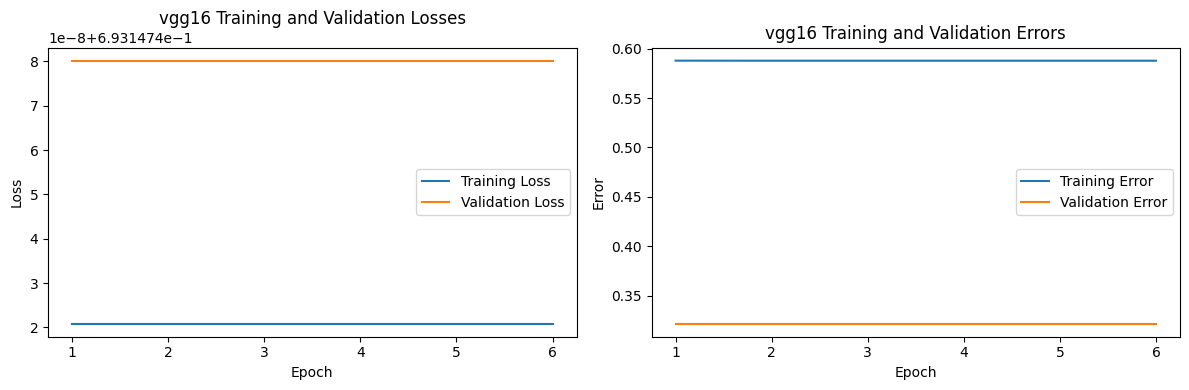

vgg16 - Precision: 0.1187, Recall: 0.3445, F1 Score: 0.1766


/home/yifan/miniconda3/envs/swin/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
from torchvision import models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_names = ['efficientnet_b0', 'resnet50', 'vgg16']
models_dict = {}
for model_name in model_names:
    if model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        last_layer_name, last_layer = list(model.named_children())[-1]
        linear_layer = last_layer[1]
        in_features = linear_layer.in_features
        print(f'efficientnet_b0 net\'s fc layer in_features num is: {in_features}')
        
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        last_layer_name, last_layer = list(model.named_children())[-1]
        in_features = last_layer.in_features
        print(f'resnet50 net\'s fc layer in_features num is: {in_features}')
        
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        last_layer_name, last_layer = list(model.named_children())[-1]
        linear_layer = last_layer[0]
        in_features = linear_layer.in_features
        print(f'vgg16 net\'s fc layer in_features num is: {in_features}')
    
    model = nn.Sequential(*list(model.children())[:-1])
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = True

    models_dict[model_name] = model

class Classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        x = self.relu(x)
        x = self.softmax(x)
        return x

def train_model(model, model_name, train_loader, val_loader, num_epochs=10, lr=0.001, patience=5):
    # Define the classifier
    if model_name == 'efficientnet_b0':
        classifier = Classifier(1280, 2).to(device)
    elif model_name == 'resnet50':
        classifier = Classifier(2048, 2).to(device)
    else:
        classifier = Classifier(25088, 2).to(device)

    model = model.to(device)

    # Loss, optimizer, and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

    # Training loop
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []   # To store training losses
    val_losses = []     # To store validation losses
    train_errors = []   # To store training errors
    val_errors = []     # To store validation errors
    
    for epoch in range(num_epochs):
        model.train()
        classifier.train()
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = torch.cat([inputs] * 3, dim=1).to(device)
            labels = labels.to(device)
            
            # Forward pass
            features = model(inputs)
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            
            # Compute training error
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_accuracy = correct_train / total_train
        train_errors.append(1 - train_accuracy)
        
        # Validation
        model.eval()
        classifier.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = torch.cat([inputs] * 3, dim=1).to(device)
                labels = labels.to(device)

                features = model(inputs)
                outputs = classifier(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Compute validation error
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_errors.append(1 - val_accuracy)
        val_loss /= len(val_loader)

        # Print training and validation losses
        print(f'{model_name} Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss}, Training Error: {train_errors[-1]}, Validation Error: {val_errors[-1]}')
        train_losses.append(loss.item())
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

        # Update scheduler
        scheduler.step(val_loss)

        
    # Plot training and validation losses
    epochs = np.arange(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training and Validation Losses')
    plt.legend()

    # Plot errors
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_errors, label='Training Error')
    plt.plot(epochs, val_errors, label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(f'{model_name} Training and Validation Errors')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_model, classifier

def evaluate_model(model, test_loader, classifier):
    model.eval()
    classifier.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = torch.cat([inputs] * 3, dim=1).to(device)
            labels = labels.to(device)
            features = model(inputs)
            outputs = classifier(features)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return precision, recall, f1

for model_name, model in models_dict.items():
    best_model_state_dict, classifier = train_model(model, model_name, train_loader, val_loader)
    model.load_state_dict(best_model_state_dict)

    # Evaluate the model
    precision, recall, f1 = evaluate_model(model, test_loader, classifier)

    # Print or store the metrics
    print(f'{model_name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

To verify our earlier hypothesis that the poor performance of transfer learning was due to freezing all parameters except the fc layer, I conducted a new round of model training without freezing any parameters. The results of this training are as follows:

- For the efficientnet_b0 network: Precision: 0.9685, Recall: 0.9683, F1 Score: 0.9683. This is an improvement compared to the CNN+MLP model.
- For the resnet50 network: Precision: 0.9484, Recall: 0.9485, F1 Score: 0.9484. This result is slightly better than the previous one.

These outcomes emphasize the value of transfer learning. However, for the vgg16 network, the performance remains poor. The loss curve exhibits little fluctuation, similar to the previous results. I speculate that this might be due to the simplicity of our fc layer, which consists of only one layer, while the original vgg16 has three fc layers.

In conclusion, unfreezing parameters during transfer learning yielded improved results for efficientnet_b0 and resnet50, emphasizing the importance of fine-tuning. Nevertheless, the challenge persists for vgg16, possibly due to the oversimplified fc layer in comparison to its original architecture.